# Analysis of Variation Types in Feature Spaces

## 1. Comparison of Performance of a Traditional Learner in Different Variation Patterns
We try to observe any recurring pattern in terms of performance when variation pattern differs.

In [1]:
import model
import dataloader as dl
import numpy as np
import trainer
import parameters as p
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

datasets = ['german', 'ionosphere', 'spambase','svmguide3','wpbc','wdbc','magic04','a8a']
model_types = ['opcbackprop','hinge_oco']


# initialize results dict
results = {}
masks = {}
occurrences = {}
errors ={}
for dataset in datasets:
    results[dataset] = {}
    masks[dataset] = {}
    occurrences[dataset] = {}
    errors[dataset] = {}
    for model_type in model_types :
        results[dataset][model_type] = 0
        masks[dataset][model_type] = []
        errors[dataset][model_type] =[]
        
for scenario in p.scenarios:
    for dataset_name in p.datasets:
        for model_type in model_types:
            Xpath, ypath = dl.get_path(dataset_name)
            X, y = dl.read_dataset(Xpath, ypath)
            num_features = len(X[0])
            m = p.models[model_type](num_features, p.learning_rate, p.num_layers[0])
            fold_errors, error_lists, fold_losses, fold_weights, fold_masks = trainer.cross_validation(X, y, m, p.folds, p.scenarios[scenario],p.cov_strength[scenario])
            masks[dataset_name][model_type] = fold_masks
            errors[dataset_name][model_type] = error_lists
            results[dataset_name][model_type] = np.mean(fold_errors)
            print(dataset_name, scenario, model_type, np.mean(fold_errors))
    print()    

    
# plot results for each dataset
'''
for dataset_name in datasets:
    plt.title(dataset_name)
    plt.ylabel('Error Rate')
    plt.bar(results[dataset_name].keys(), results[dataset_name].values())
    plt.show()
'''

'''
df = pd.DataFrame(results).T
ax = df.plot(kind="bar",figsize=(10, 10),title ="Analysis with Num_layers")
ax.set_xlabel("Dataset")
ax.set_ylabel("Error_rate")
fig = ax.get_figure()
fig.savefig('number_of_layers.png')
'''



german varying_gaussian + 0.5 opcbackprop 0.3847
german varying_gaussian + 0.5 hinge_oco 0.49915000000000004
ionosphere varying_gaussian + 0.5 opcbackprop 0.42557142857142854
ionosphere varying_gaussian + 0.5 hinge_oco 0.5211428571428571
spambase varying_gaussian + 0.5 opcbackprop 0.2699021739130435
spambase varying_gaussian + 0.5 hinge_oco 0.4956847826086956
svmguide3 varying_gaussian + 0.5 opcbackprop 0.347586484312148
svmguide3 varying_gaussian + 0.5 hinge_oco 0.44907481898632334
wpbc varying_gaussian + 0.5 opcbackprop 0.3633838383838383
wpbc varying_gaussian + 0.5 hinge_oco 0.43914141414141417
wdbc varying_gaussian + 0.5 opcbackprop 0.32548330404217923
wdbc varying_gaussian + 0.5 hinge_oco 0.5422671353251319
magic04 varying_gaussian + 0.5 opcbackprop 0.3857537199642463
magic04 varying_gaussian + 0.5 hinge_oco 0.4954045954045953
a8a varying_gaussian + 0.5 opcbackprop 0.2781525378921396
a8a varying_gaussian + 0.5 hinge_oco 0.43531899894254494



'\ndf = pd.DataFrame(results).T\nax = df.plot(kind="bar",figsize=(10, 10),title ="Analysis with Num_layers")\nax.set_xlabel("Dataset")\nax.set_ylabel("Error_rate")\nfig = ax.get_figure()\nfig.savefig(\'number_of_layers.png\')\n'

In [2]:
for key in masks:
    for scenario in p.scenarios:
        sum_masks = copy.deepcopy(masks[key][scenario][0])
        for i in range(1, len(masks[key][scenario])):
            sum_masks += masks[key][scenario][i]

        avg_sum_masks =  sum_masks / len(masks[key][scenario])
        avg_sum_masks = np.sum(avg_sum_masks, axis=0) / len(sum_masks)
        occurrences[key][scenario] = avg_sum_masks
        
        plt.title(key + scenario)
        plt.plot(occurrences[key][scenario])
        plt.show()

KeyError: 'varying_gaussian + 0.5'

**We have made two observations so far:**
1. Performance in non-uniformly distributed variation in feature spaces is worse than uniform.
2. Checking the average availability frequency of features don't immediately give an explanation about this.

After this, Jeev suggested to look at the co-occurrences of features.

## Performance vs. Feature Co-Occurrence Patterns
Let us take the *german* dataset and see how feature co-occurrences look like in different versions of the variation.
To do this, we first merge the masks from different folds of cross-validation we have.
Masks represent the feature availability in a training instance, therefore, useful when we are working on structures of feature spaces.


In [ ]:
def show_cov_mat(masks, dataset, setting):
    m = masks[dataset][setting]
    joint_mask = m[0]
    
    for i in range(1, len(m)):
        joint_mask = np.vstack((joint_mask, m[i]))
    
    cov_mat = np.cov(joint_mask.T)
    sns.heatmap(cov_mat)
    plt.show()
    return cov_mat


settings = ['full', 'varying_uniform', 'varying_gaussian']

for dataset in datasets:
    for setting in settings:
        print(dataset)
        show_cov_mat(masks, dataset, setting)

We see that an important is that varying feature spaces distribution in a uniform fashion have low covariance -> feature co-occurrence. This means feature occurrences don't follow a particular pattern. On the other hand, for gaussian, there exists various amounts of covariance between features, starting to form a pattern. This seems to be making learning harder for some reason.

**Note:** In both cases, the diagonal of the matrix seems to be 0.25. Diagonals of a covariance matrix are the variances of the components of the vector.

## Relationship Between the Amount of Covariance in Varying Gaussian and the Traditional Model Performance
In this section, we take the generator of varying_gaussian and modify it in a way that it removes features in different levels of variation.

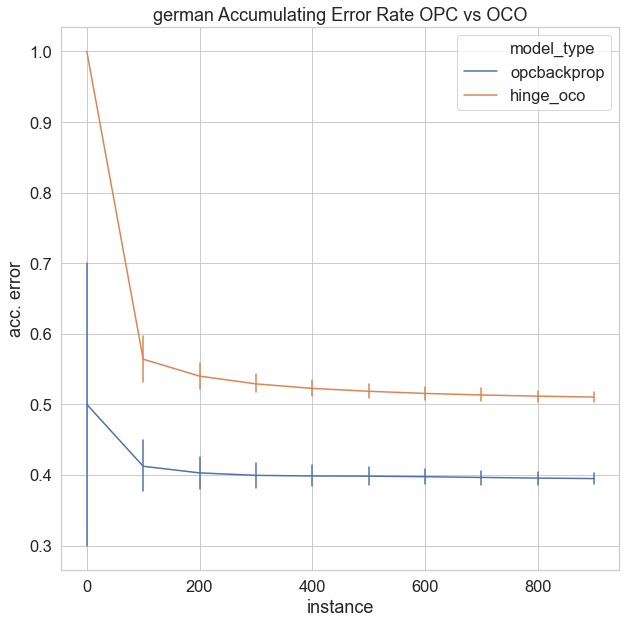

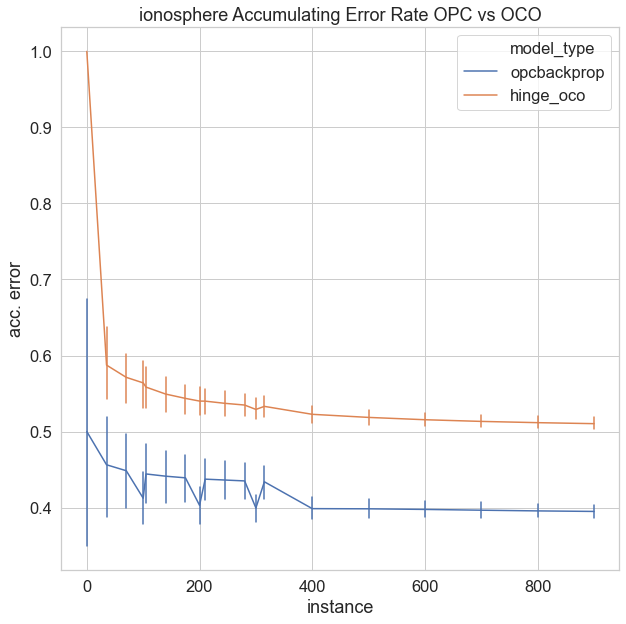

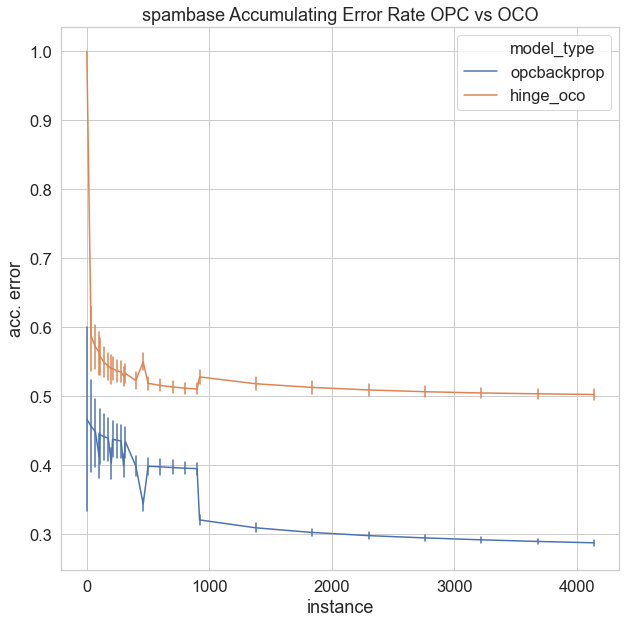

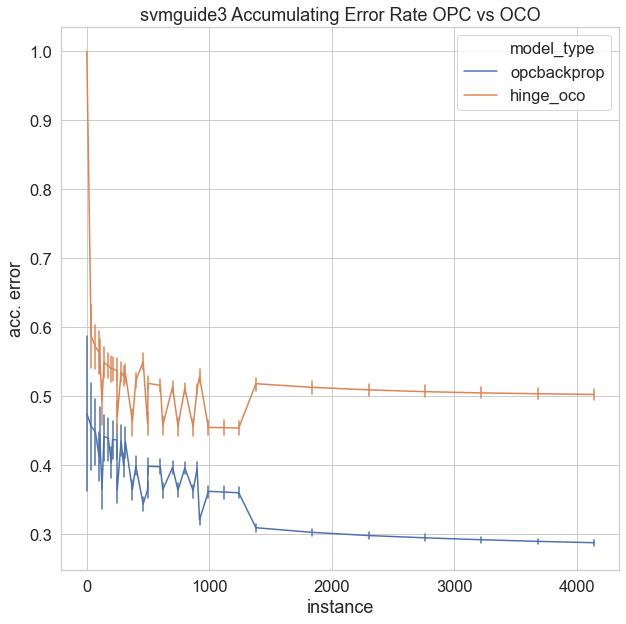

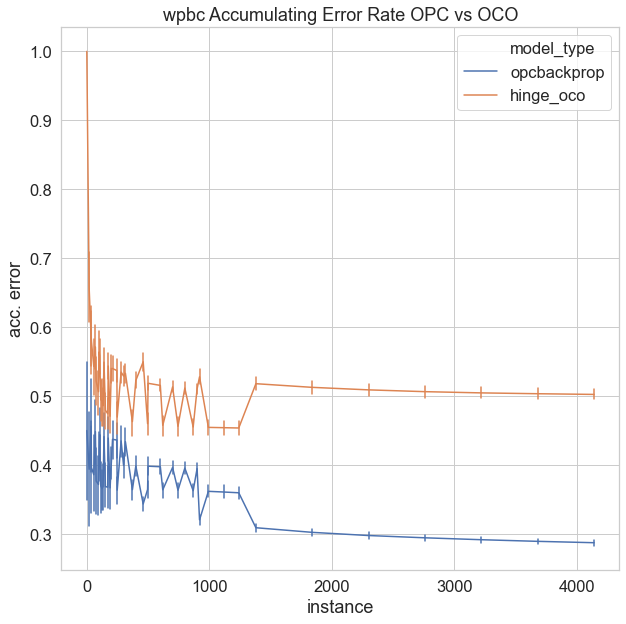

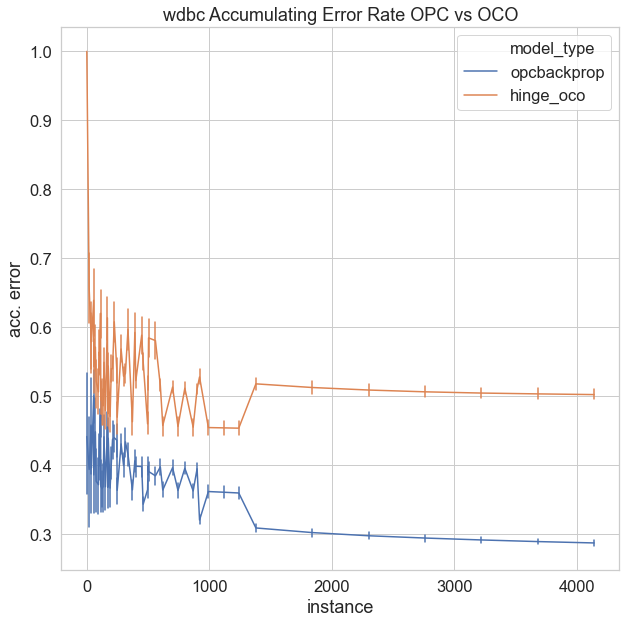

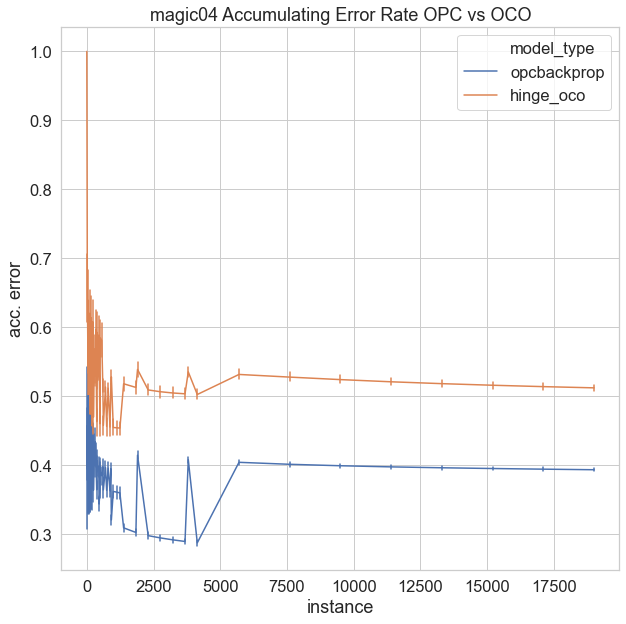

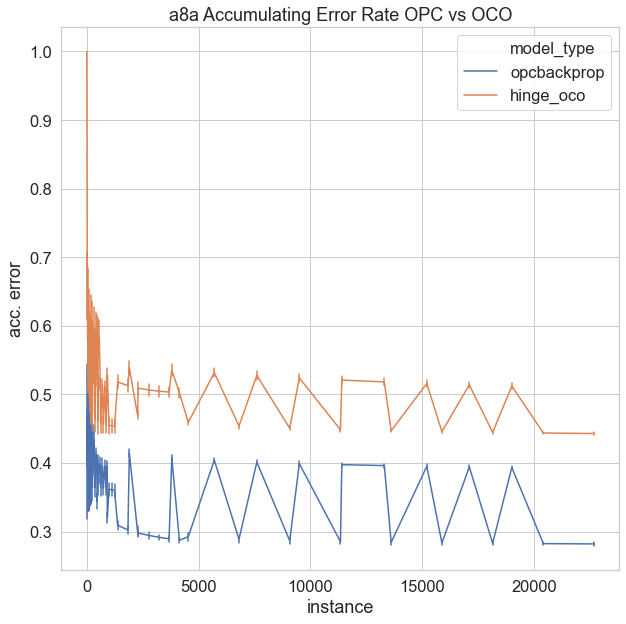

In [23]:
import pandas as pd
import seaborn as sns

data = []

# convert the dictionary of losses to a dataframe
    # columns: Scenario - timepoint - fold - value - dataset
for dataset_name in errors:
    for model_type in errors[dataset_name]:
        for fold in range(len(errors[dataset_name][model_type])):
            # calculate accumulating losses
            acc_loss = []
            acc_sum = 0
            
            for timepoint in range(len(errors[dataset_name][model_type][fold])):
                acc_sum += errors[dataset_name][model_type][fold][timepoint]
                acc_loss.append(acc_sum / float(timepoint + 1))
                
            for timepoint2 in range(len(errors[dataset_name][model_type][fold])):    
                value = acc_loss[timepoint2]
                if timepoint2 % int(0.1 * len(errors[dataset_name][model_type][fold])) == 0:
                    row = [model_type, timepoint2, fold, dataset_name, value]
                    data.append(row)

    df = pd.DataFrame(data, columns=['model_type', 'instance', 'fold', 'dataset', 'acc. error'])
    f, ax = plt.subplots(figsize=(10, 10))
    sns.set(font_scale=1.5)  # crazy big
#ax.set(yscale="log")
    sns.set_style("whitegrid")
    sns.lineplot(
        data=df, x="instance", y="acc. error", hue="model_type", err_style="bars", ci=95, ax=ax
        ).set_title(dataset_name +' Accumulating Error Rate OPC vs OCO')
    
    del df

1000